# Import packages

Due to the setting of different environment, the installing method of packages is different.


If the system is windows, open the command prompt and type:


"pip install category_encoders


pip install nltk"
(If the system is equipped with pip).


Or, open the anaconda prompt and type:


"conda install -c conda-forge category_encoders 


conda install -c anaconda nltk "
(If the system is equipped with anaconda).

In [1]:
# For the system of Linux
! pip install --user category_encoders
! pip install --user nltk

In [2]:
# For the system of Mac
! pip install category_encoders
! pip install nltk

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn import preprocessing, metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib
import matplotlib.pyplot as plt
import nltk.stem
from datetime import datetime as dt
import category_encoders as ce

#np.set_printoptions(threshold=np.nan)

Load the dataset. The training set are records since 2012 with manual labels, and the test set are raw records since 2012 without labels.

Description of the original dataset: 
https://www-odi.nhtsa.dot.gov/downloads/folders/Complaints/CMPL.txt

The dataset (with manual labels) is avaiable in this address:
https://drive.google.com/file/d/17SeAmFO6nXGVDW5-uzwXjUNWt58lZv2r/view?usp=sharing

In [2]:
data = pd.read_csv('datasince2012_train+test.csv',encoding='latin-1',error_bad_lines=False)
train = data[data['batch']==1]

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (29,37,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


To automate the future ADAS-related complaiint identified process, the model should be able to predict the future based on current information, then a time series split is needed for the model evaluation. Before we manipulate the data, we reorder the data by the report date, so that we can perform time series split directly later.

In [3]:
train = train.sort_values(by=['DATEA'])
train['DATEA'].head()

0    20111022
1    20111115
2    20120106
3    20120130
4    20120225
Name: DATEA, dtype: int64

In [4]:
test = data[data['batch']==2]
test = test.loc[(test['FAILDATE'] >= 20120101) & (test['FAILDATE'] <= 20190000)]

Check the size of data

In [5]:
ntrain = train.shape[0]
data = pd.concat([train, test], sort = False).reset_index(drop=True)
print("data size is : {}".format(data.shape))

data size is : (157602, 61)


In [6]:
train.shape

(2496, 61)

In [7]:
test.shape

(155106, 61)

In [8]:
train.loc[max(train.index)]

Unnamed: 0                                                                  2495
CMPLID                                                                   1494245
ODINO                                                                   11124051
MFR_NAME                                                   Chrysler (FCA US LLC)
MAKETXT                                                                      RAM
MODELTXT                                                                    1500
YEARTXT                                                                     2013
CRASH                                                                          N
FAILDATE                                                                20180810
FIRE                                                                           N
INJURED                                                                      NaN
DEATHS                                                                       NaN
COMPDESC                    

# Feature engineering
Build and manipulate some features based on the existing variables.

We find that since different car brands may have the same name of their car types, we cannot uniquely identify the model of the car without combineing the car's brand and the car's model. Therefore, we combine the brand (`MAKETXT`) and the car type (`MODELTXT`) to make sure the car's model is unique.

In [9]:
#The Age of car
data['FAILDATE'] = pd.to_datetime(data['FAILDATE'], format = "%Y%m%d")
data['AGE'] = data['FAILDATE'].apply(lambda x: int(str(x)[:4])) - data['YEARTXT']
data['AGE'] = data['AGE'].apply(lambda x: 0 if x < 0 else x)

#The full name of model
data['MFR_NAME'] = data['MFR_NAME'] + data['MAKETXT']

## Same model name can be used in different makes
data['MODELTXT']=data["MAKETXT"].map(str) +' '+ data["MODELTXT"]

#To distinguish different cities with same name
data['CITY'] = data['CITY'] + data['STATE']

#The month(the influence of season etc.) and the day(work day or weekend) of faildate.
data['FAILDATE'] = pd.to_datetime(data['FAILDATE'], format = "%Y%m%d")
data['FAILMONTH'] = data['FAILDATE'].apply(lambda x : x.month)
data['FAILWEEKDAY'] = data['FAILDATE'].dt.dayofweek

Select the variables that are useful in the model.

`ODINO` (NHTSA's  internal reference number) is only useful for data cleaning later, we will drop this column before we fit the model.

In [10]:
cols_use = ['ODINO','MFR_NAME', 'YEARTXT', 'MAKETXT', 'MODELTXT', 'CRASH', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE', 'MILES',
            'OCCURENCES', 'CDESCR', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'VEH_SPEED', 'AGE', 'FAILMONTH', 'FAILWEEKDAY','ADAS']
data = data[cols_use]

Set letters in the complaint and description of components lower case.

In [11]:
data["CDESCR"] = data["CDESCR"].apply(lambda x : str(x).lower())
data["COMPDESC"] = data["COMPDESC"].apply(lambda x : x.lower())

# Brief description about the numeric variable to handle outliers

In [12]:
data.describe()

,ODINO,YEARTXT,INJURED,DEATHS,MILES,OCCURENCES,VEH_SPEED,AGE,FAILMONTH,FAILWEEKDAY,ADAS
count,1.576020e+05,157602.000000,56182.000000,53547.000000,1.291350e+05,43247.000000,104146.000000,157602.000000,157602.000000,157602.000000,157602.000000
mean,1.086542e+07,2013.748493,0.183404,0.008927,3.483297e+04,1.190348,30.761642,1.958091,6.379170,2.667942,0.029467
std,1.886683e+05,1.559546,0.735022,0.494464,8.532986e+04,1.220660,29.439233,1.715441,3.321202,1.918884,0.169111
min,1.033260e+07,2012.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.070619e+07,2012.000000,0.000000,0.000000,5.000000e+03,1.000000,5.000000,0.000000,4.000000,1.000000,0.000000
50%,1.090314e+07,2013.000000,0.000000,0.000000,2.300000e+04,1.000000,30.000000,2.000000,6.000000,3.000000,0.000000
75%,1.103162e+07,2015.000000,0.000000,0.000000,5.162800e+04,1.000000,55.000000,3.000000,9.000000,4.000000,0.000000
max,1.112407e+07,2018.000000,99.000000,99.000000,9.000443e+06,100.000000,999.000000,6.000000,12.000000,6.000000,1.000000


We find outliers in INJURED (number of people injured in the accident), DEATHS (number of people dead in the accident), OCCURENCES (number of the mulfunction condition occured), VEH_SPEED (the speed of the car when the accident happened).

- After we sort the records by 'INJURED' and 'DEATHS', we find the record having 99 in 'INJURED' and 'DEATHS' are from one complaint, and record having 50 in 'INJURED' and 'DEATHS' are from another complaint. When we look at the content of the complaints, they are not about the desciptions of the accident, then we set the 'INJURED' and 'DEATHS' in these two records(ODINO 11101150 and 11101553) as missing.

- Next, we inspect the outliers in 'OCCURENCES', we find in these records, most complaints mention the approximate occurrence times, so we keep the original values.

- Finally we check the outliers in 'VEH_SPEED', we find for those records with speed greater than 140 mph, most of them are filled incorrectly based on the content of the complaint. So we set all VEH_SPEED' greater than 140 as missing.

In [13]:
data = data.replace({'INJURED': [50,99], 'DEATHS': [50,99]}, np.nan)
data['VEH_SPEED'] = data['VEH_SPEED'].apply(lambda x: x if x <= 140 else np.nan)

# Handle "NA"

In [14]:
data.isnull().sum()

ODINO                  0
MFR_NAME               0
YEARTXT                0
MAKETXT                0
MODELTXT               0
CRASH                  0
FIRE                   0
INJURED           101422
DEATHS            104057
COMPDESC               0
CITY                   7
STATE                  0
MILES              28467
OCCURENCES        114355
CDESCR                 0
ANTI_BRAKES_YN       339
CRUISE_CONT_YN       339
VEH_SPEED          53564
AGE                    0
FAILMONTH              0
FAILWEEKDAY            0
ADAS                   0
dtype: int64

- For `INJURED` and `DEATHS`, we use 0 to fill the null value.
- For `CITY`, we use a string to fill the null value.
- For `MILES` (the miles of the car), we fill the null value with median of the `MILES` in the training set, then add some random noise from the normal distribution ranged from 0 to 3000 (we decide the noise range based on the scale of this column).
- For `OCCURENCES`, we use 1 to fill the null value.
- For `VEH_SPEED`, we fill the null value with the median of the `VEH_SPEED`, then add some random noise from the normal distribution ranged from 0 to 10.
- For `MEDICAL_ATTN` (Was medical attention required) and `VEHICLES_TOWED_YN` (Was vehicle towed), since they are binary of "Y" (yes) and "N" (no), we decide to use "N" to fill the null value.

In [15]:
np.random.seed(2333)

In [16]:
## fill na
data['INJURED'] = data['INJURED'].fillna(0)
data['DEATHS'] = data['DEATHS'].fillna(0)
data['CITY'] = data['CITY'].fillna('NA')
data['MILES'] = data['MILES'].fillna(data[:ntrain]['MILES'].median())+np.random.normal(0,3000)
data['VEH_SPEED'] = data['VEH_SPEED'].fillna(data[:ntrain]['VEH_SPEED'].median()) + np.random.normal(0,10)
data['OCCURENCES'] = data['OCCURENCES'].fillna(1)
data['ANTI_BRAKES_YN'] = data['ANTI_BRAKES_YN'].fillna('N')
data['CRUISE_CONT_YN'] = data['CRUISE_CONT_YN'].fillna('N')

In [17]:
data.isnull().sum().sum()

0

Now the data have no missing value.

Next we handle duplicated rows. 
Base on the description for the dataset, we notice when a consumer reports an accident, it will create multiple records in the dataset if the consumer reports the issue on multiple components, which means we have duplicated rows but the COMPDESC(component description) are different.

In [18]:
# an example for duplicated rows, but the COMPDESC is different
data[data.ODINO==10915684]

,ODINO,MFR_NAME,YEARTXT,MAKETXT,MODELTXT,CRASH,FIRE,INJURED,DEATHS,COMPDESC,...,MILES,OCCURENCES,CDESCR,ANTI_BRAKES_YN,CRUISE_CONT_YN,VEH_SPEED,AGE,FAILMONTH,FAILWEEKDAY,ADAS
84296,10915684,Ford Motor CompanyFORD,2015,FORD,FORD TRANSIT,Y,N,9.0,9.0,structure:body,...,128895.290775,1.0,i had rented the ford transit from enterprise ...,N,N,25.728497,0,11,3,0
84297,10915684,Ford Motor CompanyFORD,2015,FORD,FORD TRANSIT,Y,N,9.0,9.0,air bags,...,128895.290775,1.0,i had rented the ford transit from enterprise ...,N,N,25.728497,0,11,3,0
84298,10915684,Ford Motor CompanyFORD,2015,FORD,FORD TRANSIT,Y,N,9.0,9.0,seats,...,128895.290775,1.0,i had rented the ford transit from enterprise ...,N,N,25.728497,0,11,3,0
84299,10915684,Ford Motor CompanyFORD,2015,FORD,FORD TRANSIT,Y,N,9.0,9.0,seat belts,...,128895.290775,1.0,i had rented the ford transit from enterprise ...,N,N,25.728497,0,11,3,0


One solution is to change the format of the dataset. We can create the dummies variables for COMPDESC and merge those duplicated rows.

In [19]:
# Drop duplicated rows
unique_odino_df = data.drop(columns = 'COMPDESC').drop_duplicates('ODINO')

In [20]:
# Check the values in COMPDESC
comp = data['COMPDESC'].drop_duplicates().sort_values()
comp.head()

65                                                 air bags
79887                      air bags: air bag control module
2413                                  air bags: clockspring
134291    air bags: occupant classification system - ocs...
2778                                       air bags:frontal
Name: COMPDESC, dtype: object

We can see for `air bags: air bag control module`, it should be a part of `air bag`. If we simply get dummies variables based on the values in COMPDESC, then there are rows having 1 in  `air bags: air bag control module` but having 0 in `air bags`. To solve this problem, we split the component combination into individual components. For each row, if the an individual component was included in the combination, then we set individual component to 1.

In [21]:
comp_list = []
# for each level in COMPDESC
for x in comp:
    # split the component combination
    x_split = x.split(":")
    for i in x_split:
            i = i.strip()
            # append the individual component to the list
            if i not in comp_list:
                comp_list.append(i)

In [22]:
# drop exact same rows, keep rows have same ODINO but different COMPDESC
comp_df = data[["ODINO", "COMPDESC"]].drop_duplicates()

for col in comp_list:
    # create a new binary column for each component
    comp_df[col] = 0
    for i in comp_df.index:
        # set the value to 1 if the individual component is included in COMPDESC(component combination)
        if col in comp_df.loc[i, "COMPDESC"]:
            comp_df.loc[i, col] = 1
    # rename the column for the convenience of further analysis
    comp_df = comp_df.rename(columns={col:"comp_"+col})
    
comp_df.head()

,ODINO,COMPDESC,comp_air bags,comp_air bag control module,comp_clockspring,comp_occupant classification system - ocs (front passenger),comp_frontal,comp_driver side inflator module,comp_sensor/control module,comp_knee bolster,...,comp_rearview mirrors/devices,comp_exterior,comp_interior,comp_sun roof assembly,comp_windshield wiper/washer,comp_wheels,comp_cap/cover/hub,comp_center section,comp_lugs/nuts/bolts,comp_rim
0,10432460,steering,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10435675,vehicle speed control,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10442757,"service brakes, hydraulic",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10445803,electrical system,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10449316,engine and engine cooling,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To merge the information for duplicated rows, we group those rows, sum up all new created binary columns within the group, then delete duplicated rows. 

In [23]:
# Sum up all new created binary columns
comp_df = comp_df.groupby('ODINO').sum().reset_index()
comp_df.head()

,ODINO,comp_air bags,comp_air bag control module,comp_clockspring,comp_occupant classification system - ocs (front passenger),comp_frontal,comp_driver side inflator module,comp_sensor/control module,comp_knee bolster,comp_on-off switch assembly,...,comp_rearview mirrors/devices,comp_exterior,comp_interior,comp_sun roof assembly,comp_windshield wiper/washer,comp_wheels,comp_cap/cover/hub,comp_center section,comp_lugs/nuts/bolts,comp_rim
0,10332595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10432460,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10435675,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10442321,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10442757,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Join the aggregated columns back to the remaining dataframe 
clean_data = pd.merge(unique_odino_df, comp_df, how = "left", on = 'ODINO')

In [25]:
# Check whether the example found before is fixed
clean_data.loc[clean_data["ODINO"] == 10915684]

,ODINO,MFR_NAME,YEARTXT,MAKETXT,MODELTXT,CRASH,FIRE,INJURED,DEATHS,CITY,...,comp_rearview mirrors/devices,comp_exterior,comp_interior,comp_sun roof assembly,comp_windshield wiper/washer,comp_wheels,comp_cap/cover/hub,comp_center section,comp_lugs/nuts/bolts,comp_rim
60076,10915684,Ford Motor CompanyFORD,2015,FORD,FORD TRANSIT,Y,N,9.0,9.0,CENTERTX,...,0,0,0,0,0,0,0,0,0,0


Split the data back to training set and test set, the data is ready for model building now.

In [26]:
# Update the index for the training set since we delete rows
ntrain = data[:ntrain]['ODINO'].nunique()

adas = clean_data[:ntrain]['ADAS']
df = clean_data.drop(columns = ['ODINO','ADAS'])
train = df[:ntrain]
test = df[ntrain:]

# Fit model with sklearn pipeline

Define cross validation strategy. Time series split allows the model to simulate the forecasting process based on current information.

In [27]:
#cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
cv = TimeSeriesSplit(n_splits=5) 

Categorize different features, we are going to extract these feaures and run different transformers on them later.
- For text features, we count the tf-idf value for the words.
- For categorical features, we run one-hot encoding.
- For numeric features(including the binary columns for COMPDESC), we delete empty columns to avoid data leakage.

In [28]:
label_feats=['YEARTXT','FAILMONTH','FAILWEEKDAY']
text_feat= ['CDESCR']
cat_feats = set(train.dtypes[train.dtypes == "object"].index) - set(text_feat) | set(label_feats)
num_feats = set(train.dtypes[train.dtypes != "object"].index) - set(label_feats)

FactorExtractor are used to extract categorical features, text feature and numeric features individually in the pipeline.

In [29]:
class FactorExtractor(TransformerMixin, BaseEstimator):
    """
    In: pd.DataFrame
        Column in that Frame
    Out: pd.Series
    
    In: pd.DataFrame
        list of Columns in that Frame
    Out: pd.DataFrame
    """

    def __init__(self, factor):
        self.factor = factor

    def transform(self, data):
        return data.loc[:,self.factor]

    def fit(self, *_):
        return self


Earlier we get dummies variables for COMPDESC on the whole dataset, it is possible that when we train the model, there are empty columns in the training set, because information are leaked from test set to training set. To avoid data leakage, we have to delete these empty columns in each cross - validation loop. 

In [30]:
class ColumnDeleter(TransformerMixin, BaseEstimator):
    """
    Delete columns with all - zero values in training set.
    """

    def transform(self, data):
        return data.drop(columns = self.col)
    
    def fit(self, data, *_):
        self.col = data.columns[(data == 0).all()]
        return self

OneHotEncoder are used to encode categorical features

In [31]:
encoder = ce.OneHotEncoder(cols = cat_feats,return_df=False,use_cat_names=True,handle_unknown='ignore')

Initialize NMF for non-negative matrix factorization

In [32]:
nmf = NMF(init='random', random_state=0)

Initialize tfidf_vectorizer to apply stemming and english stop words on text

In [33]:
# allow stemming in Sklearn TfidfVectorizer
en_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([en_stemmer.stem(w) for w in analyzer(doc)])

tfidf_vectorizer= StemmedTfidfVectorizer(analyzer="word", stop_words='english')

In [34]:
gbm = GradientBoostingClassifier(learning_rate=0.05)

Extract categorical features, text feature and numeric features individually, run different transformer on these features within the pipeline, then we use feature union to merger these features back.

In [85]:
catpipe=Pipeline([ ('cat_extractor',FactorExtractor(cat_feats)),
                   ('encode', encoder)
                  ])

numpipe=Pipeline([ ('feat_extractor',FactorExtractor(num_feats)),
                   ('deleter', ColumnDeleter())
                  ])

# extract the value in the list, so we can pass a pd series to the vectorizer, instead of a 1-column dataframe
textpipe=Pipeline([('text_extractor', FactorExtractor(text_feat[0])),  
                   ('tfidf',tfidf_vectorizer)
                  ])

feat_union=FeatureUnion([('text',textpipe),
                         ('num',numpipe),
                         ('cat',catpipe)
                        ])


pipe=Pipeline([ ('union',feat_union),
                ('clf',gbm)
              ])

Define hyper parameters to search

In [36]:
param_dist=dict(union__text__tfidf__max_df=[s/float(100) for s in range(50, 90, 5)],
                union__text__tfidf__min_df=range(1,15),
                union__text__tfidf__ngram_range=[(1,3),(1,4),(1,5)],
                clf__loss=['deviance','exponential'],
                clf__n_estimators=[100,200],
                clf__subsample=[s/float(100) for s in range(50, 101, 2)],
                clf__max_features=[s/float(100) for s in range(1, 80, 3)],
                clf__max_depth=range(2,5),
                clf__min_samples_leaf=range(5,30,3),
                clf__min_samples_split=range(5,30),
                clf__random_state =range(1,10))

model=RandomizedSearchCV(pipe,param_dist,cv=cv,n_iter=30,random_state=1,scoring="roc_auc")

In [37]:
model.fit(train,adas.values)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('text_extractor', FactorExtractor(factor='CDESCR')), ('tfidf', StemmedTfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
            dtype=<class 'numpy.float64'>, encod...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'union__text__tfidf__max_df': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85], 'union__text__tfidf__min_df': range(1, 15), 'union__text__tfidf__ngram_range': [(1, 3), (1, 4), (1, 5)], 'clf__loss': ['deviance', 'exponential'], 'clf__n_estimators': [100, 200], 'clf__subsample': [0.5,...s_leaf': range(5, 30, 3), 'clf__min_samples_split': rang

In [38]:
model.best_score_

0.9152780538383621

In [125]:
model.cv_results_

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zengweihao/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zengweihao/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zengweihao/

{'mean_fit_time': array([10.01019521,  9.19531717,  8.83359222,  7.21237731,  9.47651849,
         6.49184165,  7.93178859,  6.83393288,  7.6179512 ,  9.99534721,
         8.54557743,  8.71856599,  8.08796515,  6.68608675,  6.45961671,
         5.93493495,  9.32043743,  6.32747722,  8.70471835,  5.99077635,
         7.55217962,  5.65178132, 17.97966247,  6.93478193,  7.84740343,
        30.85404611,  9.08409677,  7.06422977,  7.18138518,  7.7714447 ]),
 'mean_score_time': array([3.69876037, 3.25313282, 2.72548862, 2.27852483, 3.07275281,
        2.37372732, 2.64323173, 2.27663875, 2.73506021, 3.08559289,
        3.01778913, 3.00188265, 2.92755599, 2.48504534, 2.2887794 ,
        2.32617617, 3.00404515, 2.25999899, 2.67047582, 2.26799173,
        2.64130673, 2.26971302, 3.07864337, 2.24097629, 2.60795317,
        2.45079947, 3.06524806, 2.56470532, 2.70434456, 2.68933182]),
 'mean_test_score': array([0.86682293, 0.82994413, 0.88559048, 0.88350958, 0.9042499 ,
        0.83588829, 0.82042

In [67]:
model.best_params_

{'clf__loss': 'exponential',
 'clf__max_depth': 2,
 'clf__max_features': 0.43,
 'clf__min_samples_leaf': 5,
 'clf__min_samples_split': 24,
 'clf__n_estimators': 200,
 'clf__random_state': 8,
 'clf__subsample': 0.88,
 'union__text__tfidf__max_df': 0.7,
 'union__text__tfidf__min_df': 1,
 'union__text__tfidf__ngram_range': (1, 5)}

To check the feature importance, we need to extract the feature names from each part of feature union

In [108]:
textpipe_names = model.best_estimator_.named_steps['union'].transformer_list[0][1].named_steps['tfidf'].get_feature_names()
numpipe_names = model.best_estimator_.named_steps['union'].transformer_list[1][1].fit_transform(train).columns
catpipe_names = model.best_estimator_.named_steps['union'].transformer_list[2][1].named_steps['encode'].get_dummies(train[list(cat_feats)]).columns
col_names = list(textpipe_names) + list(catpipe_names) + list(numpipe_names)

In [112]:
feature_importances = pd.DataFrame(model.best_estimator_.named_steps['clf'].feature_importances_,
                                   index = col_names,
                                   columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [113]:
feature_importances.head(20)

,importance
camera,0.160875
collis,0.125415
emergency brak,0.078193
park assist,0.072295
automatic brak,0.065952
blind spot,0.055111
adaptive cruis,0.054910
adapt,0.040588
brake,0.028515
autonom,0.026939


In [115]:
test.shape

(110532, 301)

In [114]:
# test set is too big, it will raise error on prediction
# split the test set to serveral data sets for prediction
test_dict = {}
pred_dict = {}
for i in range(1, 7):
    test_dict['test' + str(i)] = test[20000 * (i - 1):20000 * i]
    print('part ' + str(i) + ' created.')
    pred_dict['prediction' + str(i)] = model.predict(test_dict['test' + str(i)])
    print('part ' + str(i) + ' predicted')

part 1 created.
part 1 predicted
part 2 created.
part 2 predicted
part 3 created.
part 3 predicted
part 4 created.
part 4 predicted
part 5 created.
part 5 predicted
part 6 created.
part 6 predicted


Make prediction on the test set

In [116]:
prediction = pred_dict['prediction1']
for i in range(2, 7):
    prediction = np.concatenate((prediction, pred_dict['prediction' + str(i)]), axis=None)

test['prediction'] = prediction

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [117]:
test.to_csv('datasince2012_test_predicted.csv')

Get 100 samples which have positive prediciton, then we manually review these results to test the performance of the model.

In [118]:
test_sample=test[test['prediction']==1].sample(n=100,random_state=0)

In [119]:
test_sample.to_csv('datasince2012_test_predicted_sample100.csv')

Combine the test set with training set, then we get all data labeled after 2012

In [120]:
train['prediction'] = adas.values

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [121]:
alldata=pd.concat([train,test])
alldata.to_csv('datasince2012_all_labeled.csv')

In [122]:
test_sample.shape

(100, 302)

In [123]:
test.shape

(110532, 302)

In [124]:
alldata.shape

(112966, 302)

After we train the model, we refit the best test pipeline to get the document by term matrix with tf-idf values, then we may run text analysis on this matrix

In [118]:
# get the text pipeline with the best hyper parameter set
best_textpipe = model.best_estimator_.steps[0][1].transformer_list[0][1]

# use the best text pipeline to transform the test set
# then we get a np arrary of tf-idf values in the document by term matrix
text_data = best_textpipe.transform(test).toarray()

# extract the word for each column
text_cols = best_textpipe.steps[1][1].get_feature_names()

# use the column name and values to create a pd dataframe
text_df = pd.DataFrame(data = text_data, columns = text_cols)

To perform NMF on document by term matrix, we need to specify the rank. Since we cannot find any resouce about scree plot for NMF, we run scree plot for SVD to simulate the rank for NMF

/Users/zengweihao/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1192: MatplotlibDeprecationWarning:


Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.



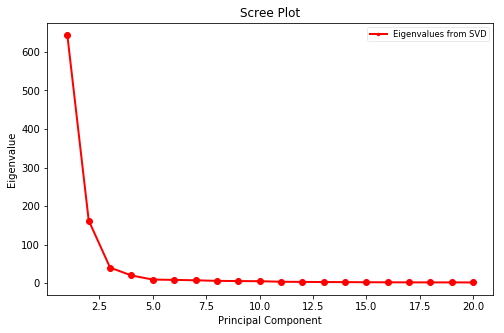

In [152]:
A = text_data
num_vars=A.shape[1]
A = np.asmatrix(A.T) * np.asmatrix(A)
U, S, V = np.linalg.svd(A) 
eigvals = S**2 / np.cumsum(S)[-1]
eigvals = eigvals[:20]
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(20) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

From the above plot, we can see the eigenvalue converges when the number of component reaches 3 or 4, indicating 3 or 4 can be a good number of components for matrix fatorization.

Define a function to print the words for each topic from NMF, and we may try different number of components around 4 to check whether the topic make sense.

In [ ]:
from __future__ import print_function
from time import time

n_components = 3
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


print("Loading dataset...")
t0 = time()
dataset = test
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
t0 = time()
tfidf = best_textpipe.transform(dataset)
print("done in %0.3fs." % (time() - t0))


In [169]:
n_components = 3

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 16.710s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer warn mph 2012 illumin 2013
Topic #1: car light drive problem vehicl time start engin turn issu stop happen steer brake power dealership tr mile recal park
Topic #2: contact recal part repair manufactur campaign nhtsa receiv number avail notif exceed unavail experienc reason state tl own confirm bag



In [170]:
n_components = 4

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 12.193s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer warn mph 2012 illumin 2013
Topic #1: car drive light problem vehicl engin start time turn issu stop steer happen brake power dealership acceler mile tr recal
Topic #2: contact recal part repair manufactur campaign nhtsa receiv number avail notif exceed unavail experienc reason state tl own confirm bag
Topic #3: door ajar close latch lock open driver light stay passeng interior ford unlock rear dome sensor shut seat handl remain



In [171]:
n_components = 5

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 17.205s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer warn mph 2012 illumin 2013
Topic #1: car drive engin problem start light time turn vehicl stop issu steer happen power brake acceler dealership mile transmiss park
Topic #2: contact repair part recal manufactur campaign nhtsa receiv number notif avail exceed unavail experienc reason state tl own confirm failur
Topic #3: door ajar close latch lock open driver light stay interior ford passeng unlock dome shut rear sensor handl remain batteri
Topic #4: airbag air bag seat passeng recal deploy takata belt driver crack light vehicl tire did crash injuri rear accid safeti



In [126]:
n_components = 6

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features ")
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = best_textpipe.steps[1][1].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Fitting the NMF model (Frobenius norm) with tf-idf features 
done in 15.303s.

Topics in NMF model (Frobenius norm):
Topic #0: failur vehicl contact mileag tl own manufactur approxim diagnos repair notifi 000 taken state dealer mph warn 2012 illumin 2013
Topic #1: car engin start drive problem time light stop vehicl issu brake happen acceler transmiss dealership turn park mile tr dealer
Topic #2: contact repair part recal manufactur campaign nhtsa receiv number notif avail exceed unavail experienc reason state tl own confirm failur
Topic #3: door ajar close latch lock open driver light stay interior ford passeng unlock dome shut rear sensor handl remain batteri
Topic #4: airbag air bag seat passeng recal deploy takata belt driver crack light tire vehicl did crash injuri rear accid safeti
Topic #5: steer power wheel turn drive assist lock lost control difficult loss right left vehicl ford make warn highway road fault

